# Confusion Score Study

In [2]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np

# import cs
folderpath="/beegfs/desy/user/bornemaf/data/syreal_output/example/std/cs"

files = [f for f in listdir(folderpath) if (isfile(join(folderpath, f)) and f.endswith('.csv'))]

def combine_cs(N, files, parentdir, M=0):
    DF = None
    for file in files:
        n = int(file.split('/')[-1].split('.')[0].split('_')[-1]) # extract the sample number from file name
        if n <= N and n >= M:
            df = pd.read_csv(join(parentdir,file), index_col=0).dropna(how='any')
            df['cs'] = df['cs'] / np.sum(df['cs'])
            if DF is None:
                DF = df
            else:
                DF = pd.concat([DF, df], axis=0).reset_index(drop=True)           
    return DF

               sigma          theta            cs
count  500000.000000  500000.000000  5.000000e+05
mean        2.000125       1.998837  1.000000e-05
std         0.577733       0.577532  1.493148e-04
min         1.000001       1.000003  6.357000e-08
25%         1.498995       1.497319  1.197548e-06
50%         1.999909       1.997977  4.496394e-06
75%         2.501364       2.498565  9.909770e-06
max         2.999994       2.999998  6.753970e-02


In [38]:
import numpy as np
import seaborn as sns
sns.set_theme(style="ticks")
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')

Text(0.5, 0.98, '(I.6.2) Sampling distribution (confidence score) at from 50 to 60')

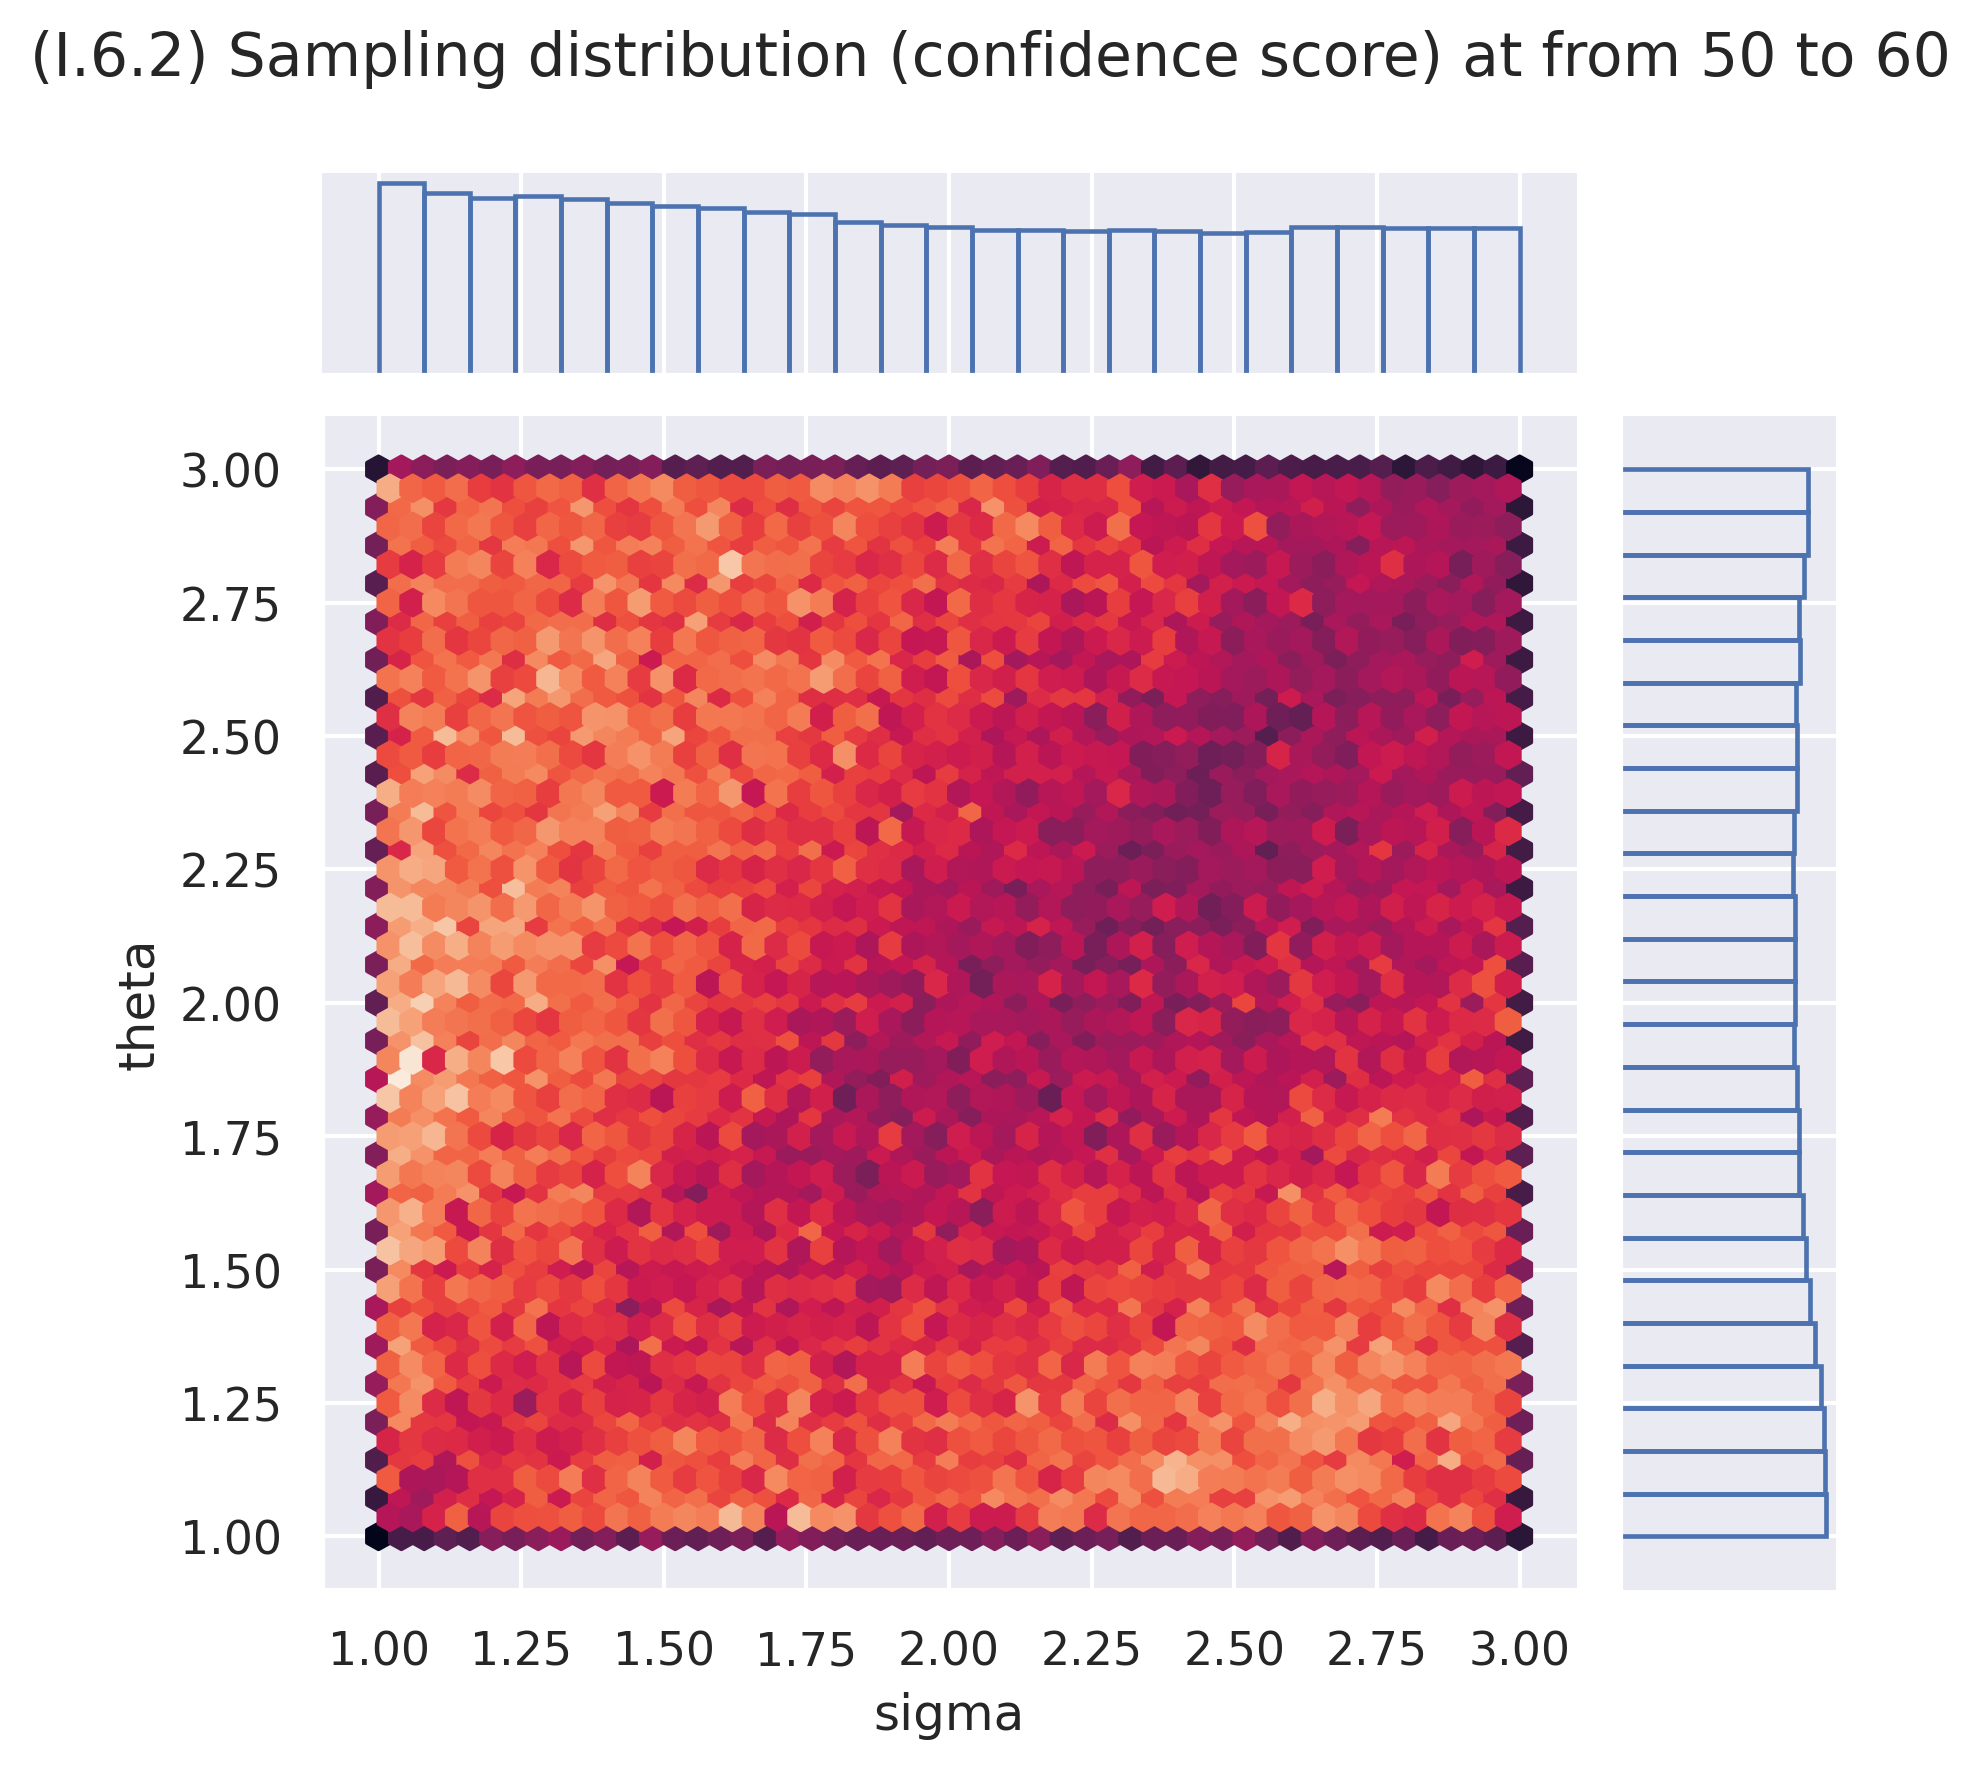

In [50]:

M=50
N=60

# load confusion score
CS = combine_cs(M=M, N=N, files=files, parentdir=folderpath)

#sample points in space based on confusion score (get distribution as histogram)
smaller_CS = CS[['sigma','theta']].sample(n=300000, weights=CS.cs)

x = smaller_CS.sigma
y = smaller_CS.theta

joint = sns.jointplot(x=x, y=y, kind="hex", cmap="rocket", marginal_ticks=False, marginal_kws=dict(bins=25, fill=False))
joint.fig.subplots_adjust(top=.9)
joint.fig.suptitle(f"(I.6.2) Sampling distribution (confidence score) at from {M} to {N}")